# Time Domain Neural Network Implementation

Time delay neural network (TDNN) is a multilayer artificial neural network architecture whose purpose is to 
- classify patterns with shift-invariance
- model context at each layer of the network. 

Shift-invariant classification means that the classifier does not require explicit segmentation prior to classification. For the classification of a temporal pattern (such as speech), the TDNN thus avoids having to determine the beginning and end points of sounds before classifying them. 
For contextual modelling in a TDNN, each neural unit at each layer receives input not only from activations/features at the layer below, but from a pattern of unit output and its context. For time signals each unit receives as input the activation patterns over time from units below. Applied to two-dimensional classification (images, time-frequency patterns), the TDNN can be trained with shift-invariance in the coordinate space and avoids precise segmentation in the coordinate space. 

<img src="tdnn1.png">
<center>TDNN Architecture</center>

## Importing libraries and settings

In [1]:
import tensorflow as tf
import pandas as pd
from datetime import datetime,date
from sklearn.model_selection import train_test_split
import numpy as np
np.set_printoptions(threshold=np.nan)
import sys
graph = tf.Graph()


## Function to get dataset

Data is obtained from United States Geological Survey [1], the latitude range for the earthquake occurences is 20°S and 40°S and longitude range is 70°E to 105°E
<img src="./dataset.png">

In [2]:
def get_dataset():
    data = pd.read_csv("/home/LOP/query_large.csv", sep=",")
    np_date = ["" for i in range(len(data))]
    data = data[296:]
    data = data.iloc[::-1]
    # use data after 1973, because before 1973 only above 5 mag earthquake were recorded
    for i, item in enumerate(data["time"]):
        np_date[i] = datetime.strptime(item[:-5], '%Y-%m-%dT%H:%M:%S')
    X = np.array(data["mag"])
    for i in range(len(X)):
        if X[i] >= 5:
            X = X[i:]
            break
    count = 1
    ans = []
    for i in range(len(X)):
        if X[i] < 5:
            count = count + 1
        else:
            ans.append(count)
            count = 0
    data_f = pd.DataFrame(data=ans, columns=['timeSinceLast'])
    return data_f

data_f = get_dataset()

data_f = np.array(data_f)

n_channels = 1
seq_len =5

X = []
y = []
for i in range(len(data_f)-seq_len-1):
    X.append(np.reshape(data_f[i:i+seq_len], -1, seq_len))
    y.append(data_f[i+seq_len])
X = np.array(X)
X = np.reshape(X, (1919, 5, 1))
y = np.vstack(y)

xtrain, xval, ytrain, yval = train_test_split(X, y)

In [3]:
xtrain.shape, xval.shape, ytrain.shape, yval.shape

((1439, 5, 1), (480, 5, 1), (1439, 1), (480, 1))

In [27]:
xtrain[1]

array([[0],
       [0],
       [4],
       [5],
       [0]])

## Declaring hyper-parameters

In [4]:
keep_prob_ = 0.2 
learning_rate_ = 0.001 

## Declaring inputs

In [5]:
inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels],name = 'inputs')
yplace = tf.placeholder(tf.float32, [None, 1],name = 'ytrue')

## Defining the network

In [33]:
import keras
from keras.layers import * 
from keras.models import Sequential 

In [31]:
model = Sequential()
model.add(Conv1D(input_shape = (5,1), filters= 18, kernel_size= 2, strides=1 , padding= 'same', activation= 'relu', name= 'conv1'))
model.add(MaxPool1D(pool_size= 2, strides= 2, name = 'mxp1')) 
model.add(Conv1D(filters= 36, kernel_size= 2, strides= 1, padding= 'same', activation= 'relu', name = 'conv2')) 
model.add(MaxPool1D(pool_size= 2, strides= 2, name= 'mxp2')) 
# model.add(Conv1D(filters= 72, kernel_size= 2, strides= 1, padding= 'same', activation= 'relu', name='conv3')) 
# model.add(MaxPool1D(pool_size= 2, strides= 2, name='mxp3')) 
# model.add(Conv1D(filters= 144, kernel_size= 2, strides= 1, padding= 'same', activation= 'relu', name= 'conv4'))  
# model.add(MaxPool1D(pool_size= 2, strides= 2, name= 'mxp4')) 
model.add(Flatten()) 
model.add(Dropout(0.2))
model.add(Dense(72)) 
model.add(Dense(1))  

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [34]:
model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adam(),
              metrics=['mse'])  

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [36]:
history = model.fit(xtrain, ytrain,
          batch_size=8,
          epochs=100,
          verbose=1,
          validation_data=(xval, yval))   

Train on 1439 samples, validate on 480 samples
Epoch 1/100
1439/1439 [==============================] - 1s 739us/step - loss: 167.2140 - mean_squared_error: 167.2140 - val_loss: 117.7968 - val_mean_squared_error: 117.7968
Epoch 2/100
1439/1439 [==============================] - 1s 723us/step - loss: 167.8529 - mean_squared_error: 167.8529 - val_loss: 118.5206 - val_mean_squared_error: 118.5206
Epoch 3/100
1439/1439 [==============================] - 1s 720us/step - loss: 166.1410 - mean_squared_error: 166.1410 - val_loss: 117.9763 - val_mean_squared_error: 117.9763
Epoch 4/100
1439/1439 [==============================] - 1s 719us/step - loss: 165.5983 - mean_squared_error: 165.5983 - val_loss: 118.7205 - val_mean_squared_error: 118.7205
Epoch 5/100
1439/1439 [==============================] - 1s 725us/step - loss: 166.2631 - mean_squared_error: 166.2631 - val_loss: 116.8778 - val_mean_squared_error: 116.8778
Epoch 6/100
1439/1439 [==============================] - 1s 737us/step - loss:

1439/1439 [==============================] - 1s 716us/step - loss: 159.1520 - mean_squared_error: 159.1520 - val_loss: 125.6716 - val_mean_squared_error: 125.6716
Epoch 48/100
1439/1439 [==============================] - 1s 718us/step - loss: 160.8842 - mean_squared_error: 160.8842 - val_loss: 124.4825 - val_mean_squared_error: 124.4825
Epoch 49/100
1439/1439 [==============================] - 1s 744us/step - loss: 157.9395 - mean_squared_error: 157.9395 - val_loss: 124.2063 - val_mean_squared_error: 124.2063
Epoch 50/100
1439/1439 [==============================] - 1s 738us/step - loss: 160.3589 - mean_squared_error: 160.3589 - val_loss: 131.8376 - val_mean_squared_error: 131.8376
Epoch 51/100
1439/1439 [==============================] - 1s 728us/step - loss: 158.6703 - mean_squared_error: 158.6703 - val_loss: 136.6096 - val_mean_squared_error: 136.6096
Epoch 52/100
1439/1439 [==============================] - 1s 722us/step - loss: 159.7078 - mean_squared_error: 159.7078 - val_loss: 1

1439/1439 [==============================] - 1s 720us/step - loss: 156.9900 - mean_squared_error: 156.9900 - val_loss: 138.9241 - val_mean_squared_error: 138.9241
Epoch 94/100
1439/1439 [==============================] - 1s 738us/step - loss: 155.2451 - mean_squared_error: 155.2451 - val_loss: 129.3474 - val_mean_squared_error: 129.3474
Epoch 95/100
1439/1439 [==============================] - 1s 741us/step - loss: 155.0729 - mean_squared_error: 155.0729 - val_loss: 136.7775 - val_mean_squared_error: 136.7775
Epoch 96/100
1439/1439 [==============================] - 1s 740us/step - loss: 154.6415 - mean_squared_error: 154.6415 - val_loss: 140.3395 - val_mean_squared_error: 140.3395
Epoch 97/100
1439/1439 [==============================] - 1s 728us/step - loss: 154.1719 - mean_squared_error: 154.1719 - val_loss: 132.8409 - val_mean_squared_error: 132.8409
Epoch 98/100
1439/1439 [==============================] - 1s 726us/step - loss: 156.1961 - mean_squared_error: 156.1961 - val_loss: 1

In [37]:
model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv1D)               (None, 5, 18)             54        
_________________________________________________________________
mxp1 (MaxPooling1D)          (None, 2, 18)             0         
_________________________________________________________________
conv2 (Conv1D)               (None, 2, 36)             1332      
_________________________________________________________________
mxp2 (MaxPooling1D)          (None, 1, 36)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 36)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 72)                2664      
__________

In [60]:
xeval = xval[:480]    # Testing on Validation Data
xeval.shape 

(480, 5, 1)

In [58]:
check = np.ones(shape=(5,1), dtype= int)   ## checking on custom Data
check 
check = np.expand_dims(check, axis =0) 
check.shape   

(1, 5, 1)

In [61]:
model.input_shape
model.predict(xeval, batch_size=1)  

array([[12.87598  ],
       [ 6.3647704],
       [ 8.070853 ],
       [23.125496 ],
       [ 5.6734247],
       [ 4.882106 ],
       [10.0422945],
       [ 5.5136786],
       [ 7.3587646],
       [ 4.7669764],
       [ 5.288428 ],
       [ 4.616654 ],
       [11.037223 ],
       [ 8.616327 ],
       [11.959892 ],
       [ 6.933659 ],
       [14.295153 ],
       [11.474173 ],
       [ 7.2336054],
       [ 9.056511 ],
       [ 4.4174805],
       [ 7.543306 ],
       [ 5.8317366],
       [10.591513 ],
       [ 6.998273 ],
       [ 8.014061 ],
       [ 6.2632623],
       [ 8.622292 ],
       [ 8.35063  ],
       [ 8.980405 ],
       [-2.112075 ],
       [ 8.561272 ],
       [ 3.4371073],
       [ 9.655453 ],
       [10.659994 ],
       [14.707037 ],
       [10.420846 ],
       [14.898195 ],
       [19.903898 ],
       [ 8.545224 ],
       [ 4.9114094],
       [ 5.5964804],
       [ 8.68326  ],
       [ 3.9695294],
       [ 4.542529 ],
       [ 8.514081 ],
       [13.407564 ],
       [ 6.06

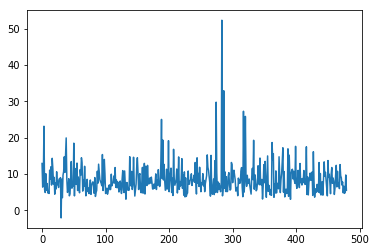

In [64]:
import matplotlib.pyplot as plt          ## Number of Earthquakes between 2 large earthquakes Prediction PLot
plt.plot(model.predict(xeval, batch_size=1))